In [32]:
%matplotlib inline
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from brokenaxes import brokenaxes
from enum import Enum
import argparse
import os
import json

import seaborn as sns

from paper import *

PLAIN_COLOR = "#4285F4"
INCREMENTAL_COLOR = '#DB4437'
COMMIT_COLOR = "#F4B400"
from enum import IntFlag

class Mode(IntFlag):
    OUT_OF_ORDER = 0
    IN_ORDER = 1
    COMMIT = 2
    INCREMENTAL = 4

In [14]:
def get_metric(path, metric, step):
    with open(path) as f:
        lines = f.read().splitlines()
        ind = lines.index("EXPERIMENTAL RESULTS") + 2
        line = lines[ind + step]
        metrics = json.loads(line)
        if metric == 'jobTime':
            return metrics[metric]
        else:
            return metrics["stages"][0][metric]

def compare_path(trial, mode):
    return "tuplex-compare-{}{}-ssd-{}.txt".format('out-of-order' if mode == Mode.OUT_OF_ORDER else 'in-order',
                                                   '-commit' if mode == Mode.COMMIT else '',
                                                   trial)


def experiment_path(trial, incremental, mode):
    return "tuplex-{}-{}{}-ssd-{}.txt".format('incremental' if incremental else 'plain',
                                              'out-of-order' if mode == Mode.OUT_OF_ORDER else 'in-order',
                                              '-commit' if mode == Mode.COMMIT else '',
                                              trial)

def get_average_times(results_path, metric, num_trials, num_steps, incremental, mode):
    times = []
    for i in range(num_steps):
        total = 0
        for j in range(num_trials):
            total += get_metric(os.path.join(results_path, experiment_path(j + 1, incremental, mode)), metric, i)
        total /= num_trials
        times.append(total)
    return np.array(times)

In [15]:
results_path = '../results/'

In [31]:
!ls ../results/zillow/

tuplex-incremental-in-order-commit-ssd-01.txt
tuplex-incremental-in-order-commit-ssd-02.txt
tuplex-incremental-in-order-commit-ssd-03.txt
tuplex-incremental-in-order-commit-ssd-04.txt
tuplex-incremental-in-order-commit-ssd-05.txt
tuplex-incremental-in-order-commit-ssd-06.txt
tuplex-incremental-in-order-commit-ssd-07.txt
tuplex-incremental-in-order-commit-ssd-08.txt
tuplex-incremental-in-order-commit-ssd-09.txt
tuplex-incremental-in-order-commit-ssd-10.txt
tuplex-incremental-in-order-ssd-01.txt
tuplex-incremental-in-order-ssd-02.txt
tuplex-incremental-in-order-ssd-03.txt
tuplex-incremental-in-order-ssd-04.txt
tuplex-incremental-in-order-ssd-05.txt
tuplex-incremental-in-order-ssd-06.txt
tuplex-incremental-in-order-ssd-07.txt
tuplex-incremental-in-order-ssd-08.txt
tuplex-incremental-in-order-ssd-09.txt
tuplex-incremental-in-order-ssd-10.txt
tuplex-incremental-out-of-order-ssd-01.txt
tuplex-incremental-out-of-order-ssd-02.txt
tuplex-incremental-out-of-order-ssd-03.txt
tuplex-incremental-ou

In [38]:

rows = []



rows

[{'run': 10,
  'path': '../results/zillow/tuplex-plain-out-of-order-ssd-10.txt',
  'step': 0,
  'order': 'out',
  'incremental': False,
  'commit': False,
  'jobTime': 25.094184398651123,
  'fast_path_time_s': 23.7726,
  'slow_path_time_s': 0.0,
  'write_output_wall_time_s': 0.220647},
 {'run': 10,
  'path': '../results/zillow/tuplex-plain-out-of-order-ssd-10.txt',
  'step': 1,
  'order': 'out',
  'incremental': False,
  'commit': False,
  'jobTime': 17.656548500061035,
  'fast_path_time_s': 14.5132,
  'slow_path_time_s': 1.48452,
  'write_output_wall_time_s': 0.68128},
 {'run': 10,
  'path': '../results/zillow/tuplex-plain-out-of-order-ssd-10.txt',
  'step': 2,
  'order': 'out',
  'incremental': False,
  'commit': False,
  'jobTime': 16.80412769317627,
  'fast_path_time_s': 14.155,
  'slow_path_time_s': 1.16423,
  'write_output_wall_time_s': 0.633427},
 {'run': 10,
  'path': '../results/zillow/tuplex-plain-out-of-order-ssd-10.txt',
  'step': 3,
  'order': 'out',
  'incremental': False

In [48]:
def load_data(results_path):
    rows = []
    paths = glob.glob(os.path.join(results_path, 'zillow/tuplex-*.txt'))
    for path in paths:
        basename = os.path.basename(path).replace('.txt', '')
        parts = basename.split('-')
        run = int(parts[-1])

        # extract experimental results
        step = 0 # from 0...6
        metric = 'jobTime'

        metrics = ['jobTime', 'fast_path_time_s', 'slow_path_time_s', 'write_output_wall_time_s']

        num_steps = 7
        for step in range(0, num_steps):
            row = {'run' : run,
             'path' : path,
             'step' : step,
             'order': 'in' if 'in-order' in basename else 'out',
             'incremental' : 'incremental' in basename,
             'commit' : 'commit' in basename
            }

            for metric in metrics:
                row[metric] = float(get_metric(path, metric, step))
            rows.append(row)
    
    return pd.DataFrame(rows)

In [49]:
df = load_data(results_path)

In [50]:
df.to_csv('zillow_incremental_consolidated.csv', index=None)

In [51]:
df.groupby(['step', 'order', 'incremental', 'commit']).mean()

run    jobTime  fast_path_time_s  \
step order incremental commit                                     
0    in    False       False   5.5  24.852811          23.56665   
           True        False   5.5  24.902349          23.62570   
                       True    5.5  24.747196          23.60616   
     out   False       False   5.5  24.902785          23.61491   
           True        False   5.5  24.896848          23.62551   
1    in    False       False   5.5  17.703688          14.48195   
           True        False   5.5   4.659300           0.00000   
                       True    5.5   4.147879           0.00000   
     out   False       False   5.5  17.506220          14.42818   
           True        False   5.5   3.891626           0.00000   
2    in    False       False   5.5  16.978058          14.15480   
           True        False   5.5   4.360099           0.00000   
                       True    5.5   3.691918           0.00000   
     out   False       False   5.5  16.890901          14.15097   
           True        False   5.5   3.393227           0.00000   
3    in    False       False   5.5  17.086825          14.22361   
           True        False   5.5   3.868664           0.00000   
                       True    5.5   3.174867           0.00000   
     out   False       False   5.5  16.904945          14.21189   
           True        False   5.5   3.004698           0.00000   
4    in    False       False   5.5  16.926724          14.11223   
           True        False   5.5   3.853264           0.00000   
                       True    5.5   3.112942           0.00000   
     out   False       False   5.5  16.863818          14.17590   
           True        False   5.5   2.918647           0.00000   
5    in    False       False   5.5  16.333121          13.97832   
           True        False   5.5   3.305922           0.00000   
                       True    5.5   2.537749           0.00000   
     out   False       False   5.5  16.247710          13.94270   
           True        False   5.5   2.446657           0.00000   
6    in    False       False   5.5  16.410752          13.96559   
           True        False   5.5   1.814791           0.00000   
                       True    5.5   1.262429           0.00000   
     out   False       False   5.5  16.277918          13.94117   
           True        False   5.5   0.996225           0.00000   

                               slow_path_time_s  write_output_wall_time_s  
step order incremental commit                                              
0    in    False       False           0.000000                  0.173354  
           True        False           0.000000                  0.190769  
                       True            0.000000                  0.000000  
     out   False       False           0.000000                  0.188295  
           True        False           0.000000                  0.179053  
1    in    False       False           1.570606                  0.682569  
           True        False           3.111993                  0.674185  
                       True            3.164592                  0.000000  
     out   False       False           1.475255                  0.668361  
           True        False           2.935128                  0.019950  
2    in    False       False           1.260007                  0.669800  
           True        False           2.735953                  0.677324  
                       True            2.768087                  0.000000  
     out   False       False           1.151430                  0.666755  
           True        False           2.500873                  0.000444  
3    in    False       False           1.254393                  0.678189  
           True        False           2.271666                  0.670030  
                       True            2.288565                  0.000000  
     out   False       False   

In [52]:
gdf_mu = df.groupby(['step', 'order', 'incremental', 'commit']).mean().reset_index()
gdf_sigma = df.groupby(['step', 'order', 'incremental', 'commit']).std().reset_index()

In [56]:
gdf_mu = gdf_mu[~gdf_mu['commit']]
gdf_sigma = gdf_sigma[~gdf_sigma['commit']]

In [131]:
# what is the total runtime?
# for each run & configuration compute cumulative cost

gdf_sum = df.groupby(['run', 'order', 'incremental', 'commit']).sum().reset_index()
df_runtime_mu = gdf_sum.groupby(['order', 'incremental', 'commit']).mean().reset_index()
df_runtime_std = gdf_sum.groupby(['order', 'incremental', 'commit']).std().reset_index()

In [134]:
def sel_row(df, order, inc):
    return df[(df['order'] == order) & (df['incremental'] == inc) & (~df['commit'])].iloc[0]

<ipython-input-169-6d46345cb41e>:8: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rc('text.latex', preamble=['\\usepackage{times,mathptmx}'])
/Users/leonhards/projects/tuplex-public/benchmarks/incremental/notebooks/paper.py:36: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rc('text.latex', preamble=['\\usepackage{times,mathptmx}'])


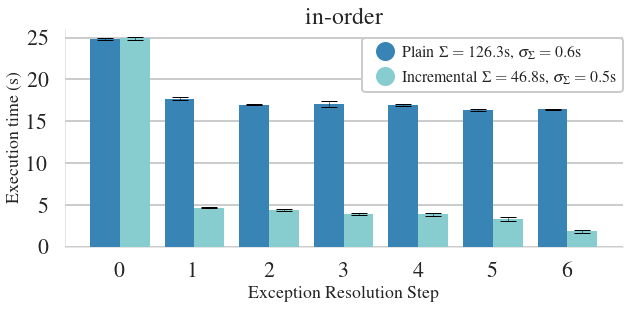

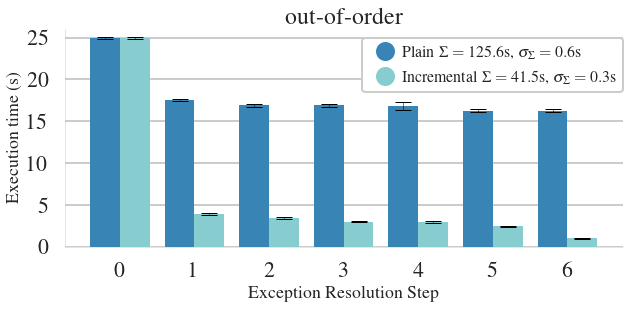

In [169]:

palette_colors = [[.22, .52, .71], [.53, .80, .81],
                  [144 / 255., 12 / 255, 63 / 255.],
                  [67 / 255., 135 / 255., 107 / 255.],
                  [248 / 255., 194 / 255., 145 / 255.]]
sns.set_palette(palette_colors)

matplotlib.rc('font', family='serif', size=9)
matplotlib.rc('text.latex', preamble=['\\usepackage{times,mathptmx}'])
matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=8)
matplotlib.rc('figure', figsize=(2.5, 1.4))
matplotlib.rc('axes', linewidth=0.5)
matplotlib.rc('lines', linewidth=0.5)

adjust_settings()

orders = ['in', 'out']
titles = ['in-order', 'out-of-order']
names = ['zillow-in-order.pdf', 'zillow-out-of-order.pdf']

for i in [0, 1]:
    order = orders[i]
    title = titles[i]
    name = names[i]
    
    if i == 0:
        sns.set_palette(palette_colors)
    else:
        sns.set_palette(np.array(palette_colors) )
    
    plt.figure(figsize=(10, 4))

    subdf_mu = gdf_mu[gdf_mu['order'] == order]
    subdf_sigma = gdf_sigma[gdf_sigma['order'] == order]

    w = .4

    data = subdf_mu[~subdf_mu['incremental']]
    data_err = subdf_sigma[~subdf_sigma['incremental']]
    plt.bar(data['step'] - w/2, data['jobTime'], w, yerr=data_err['jobTime'],
            capsize=8, edgecolor='none', linewidth=3)

    data = subdf_mu[subdf_mu['incremental']]
    data_err = subdf_sigma[subdf_sigma['incremental']]
    plt.bar(data['step'] + w/2, data['jobTime'], w, yerr=data_err['jobTime'],
            capsize=8, edgecolor='none', linewidth=3)


    sns.despine()
    plt.xlabel('Exception Resolution Step', fontsize=18)
    plt.ylabel('Execution time (s)', fontsize=18)
    plt.yticks([0, 5, 10, 15, 20, 25])
    plt.grid(axis='x')

    
     # labels
    fmt = ' $\\Sigma={:.1f}\\mathrm{{s}}$, $\\sigma_{{\\Sigma}}={:.1f}\\mathrm{{s}}$'
    r = sel_row(df_runtime_mu, order, False)
    r_err = sel_row(df_runtime_std, order, False)
    plain_label = fmt.format(r['jobTime'], r_err['jobTime'])
    
    r = sel_row(df_runtime_mu, order, True)
    r_err = sel_row(df_runtime_std, order, True)
    inc_label = fmt.format(r['jobTime'], r_err['jobTime'])
    
    hlabels=[('Plain' + plain_label, sns.color_palette()[0]),
             ('Incremental' + inc_label, sns.color_palette()[1]),]
    handles = []
    for h in hlabels:
        handles.append(Line2D([0], [0], marker='o', color='w', label=h[0],
                            markerfacecolor=h[1], markersize=20))
    plt.legend(handles=handles, fontsize=16, handletextpad=0.05, framealpha=1,
              bbox_to_anchor=(1, 1 - 1/26), loc=1, borderaxespad=0)
    plt.title(title)
    plt.ylim(0, 26)
    
    os.makedirs('plots', exist_ok=True)
    plt.savefig(os.path.join('plots', name), transparent=True, dpi=120, bbox_inches = 'tight', pad_inches = 0)

In [103]:
# cost curves (cumulative, r5d.8xlarge)

# TODO plot this => how much does a second cost?

In [117]:
!open plots